In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import pickle
!pip install kmodes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

%matplotlib inline

You should consider upgrading via the '/data/python36/consumer/crmdb-zs/crmdb-zspy36/bin/python3 -m pip install --upgrade pip' command.


In [9]:
demographic_data_filepath='hcp_demo_08_02_2022.csv'
lta_zip_map_filepath='Zip to LTA Mapping.csv'
model_filepath="kmode_model1.pkl"
predict=True#If this is true we will be using the saved pickle file as the model while if it false we will be running the model again.
label_encodinglist=['derived_speciality','State','ZIP Code','LTA_ID']
quantile_rangelist=['Total Population','Primary Care Physicians to population Ratio','People with no private health insurance','Geo Level Health Score']
L1_feature_list=['HCP_ID','LTA_ID_labelencoded', 'ZIP Code_labelencoded', 'derived_speciality_labelencoded','People with no private health insurance_quantile','Geo Level Health Score_quantile']
raw_feature_list=['HCP_ID','ZIP Code','LTA_ID','State','VOD_SPECIALITY','People with no private health insurance','Geo Level Health Score']
feature_summarise_list=['ZIP Code','LTA_ID','State','VOD_SPECIALITY']

L1_output_filepath = 'Final_L1_seg_output_08_02_22.csv'

In [3]:
#reading the data
def read_data(filepath):
    '''
    This function is used to read the data in case of valid filepath.
    filepath:location of the file
    '''
    try:
        df = pd.read_csv(filepath)           
    except:
        print("Filepath not valid")
    return df

In [4]:
#level 1 preprocessing 
#mapping with LTA
#creating quantiles and labelencodings
def L1_preprocess(df,df_lta_zip,label_encodinglist,quantile_rangelist,derived_feature_col, hcp_demo):
    '''
    This function is used for mapping zip code to LTA, creating quantiles and ranges for the features and keeping top 9 
    specialities intact whicle making others to a new category as 'others'.
    df:Raw hcp demographics dataframe 
    df_lta_zip:File used to get lta on mapping with zip codes available
    label_encodinglist:Features that needed to be encoded
    quantile_rangelist:Features that needed to be quantiled
    derived_features_col:feature that needed to be changed(ex:vod_speciality)
    '''
    #LTA-ZIP mapping creation using 'Zip to LTA Mapping.csv'
    df_lta_zip=df_lta_zip.rename(columns={'ZIPCOD':'ZIP Code'})
    df=df.merge(df_lta_zip,on=['ZIP Code'],how='left')
    df['LTA_ID']=df['LTA_ID'].fillna(99999999)
    df=df.dropna()
    if derived_feature_col!=0:
        #pick top 9 specialities from vod_speciality column and rest as others
        top9_spec_list=hcp_demo[derived_feature_col].value_counts().index.tolist()[0:9]
        df['derived_speciality']=df[derived_feature_col].apply(lambda x: x if x in top9_spec_list else 'others')#.value_counts()
    le = preprocessing.LabelEncoder()
    df=df.dropna()
    for i in label_encodinglist:
        df[i+'_labelencoded'] = le.fit_transform(df[i])
    for i in quantile_rangelist:
        df[i+'_quantile']=pd.cut(df[i],3,labels=False)
        df[i+'_range']=pd.cut(df[i],3)
    return df


In [5]:
#using elbow method to get optimal clusters
def elbow(df_preprocess,features_intomodel):
    '''
    This function is used for running elbow curve on the data to get optimal number of clusters.
    df_preprocess: processed data for L1 segmentation
    features_intomodel: list of features that we need to use for L1 segmentation
    '''
    cost = []
    K = range(1,15)
    df_final=df_preprocess[features_intomodel]
    data = df_final.set_index('HCP_ID')
    data=data.dropna()
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 1)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
    
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return data

In [6]:
#running the kmodes model  
def model(data,predict):
    '''
    This function is used to run the model with optimal clusters and processed data.
    data:Processed data to be fed into kmodes model
    n_clusters:number of clusters we get from elbow method
    
    '''
    if predict == True:
        kmode = pickle.load(open(model_filepath, "rb"))
    
    else:
        print(f"Enter number of clusters :")
        n = int(input())
        kmode = KModes(n_clusters=n, init = "random", n_init = 5, verbose=1,random_state=1000)
        pickle.dump(kmode, open("kmode_model1.pkl", "wb"))
        
    clusters = kmode.fit_predict(data)
    data.insert(0, "Segment_1", clusters, True)
    data=data.reset_index()
    return data

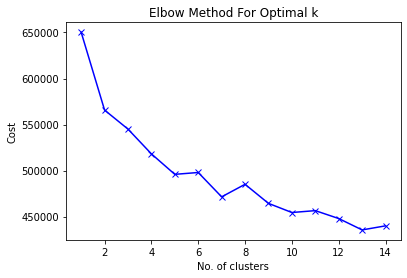

Enter number of clusters :
13
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20962, cost: 437687.0
Run 1, iteration: 2/100, moves: 425, cost: 437687.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5431, cost: 435731.0
Run 2, iteration: 2/100, moves: 5, cost: 435731.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 41179, cost: 432915.0
Run 3, iteration: 2/100, moves: 24193, cost: 431662.0
Run 3, iteration: 3/100, moves: 125, cost: 431662.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 26458, cost: 430362.0
Run 4, iteration: 2/100, moves: 590, cost: 430362.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 16119, cost: 462527.0
Run 5, iteration: 2/100, moves: 310, cost

In [7]:
def run_Level1_Segmentation():
    hcp_demo=read_data(demographic_data_filepath)
    lta_zip_map=read_data(lta_zip_map_filepath)

    L1_processed=L1_preprocess(hcp_demo,lta_zip_map,label_encodinglist,quantile_rangelist,'VOD_SPECIALITY', hcp_demo)

    elbow_output=elbow(L1_processed,L1_feature_list)
    L1_segment_output=model(elbow_output,predict)
    
    return L1_segment_output

L1_segment_output = run_Level1_Segmentation()
#L1_segment_output.to_csv(L1_output_filepath, index = False)


In [8]:
L1_segment_output.head()

,HCP_ID,Segment_1,LTA_ID_labelencoded,ZIP Code_labelencoded,derived_speciality_labelencoded,People with no private health insurance_quantile,Geo Level Health Score_quantile
0,H0000000000015,2,2164,6016,2,1,0
1,H0000000000104,5,999,6762,7,0,1
2,H0000000000140,8,1844,15425,9,1,0
3,H0000000000169,8,1208,5780,9,1,0
4,H0000000000176,3,2135,3662,9,0,0


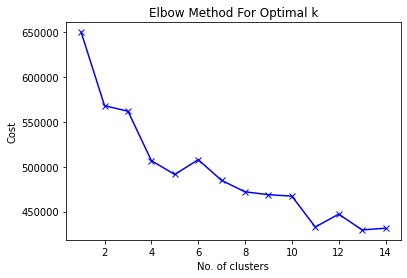

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20962, cost: 437687.0
Run 1, iteration: 2/100, moves: 425, cost: 437687.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5431, cost: 435731.0
Run 2, iteration: 2/100, moves: 5, cost: 435731.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 41179, cost: 432915.0
Run 3, iteration: 2/100, moves: 24193, cost: 431662.0
Run 3, iteration: 3/100, moves: 125, cost: 431662.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 26458, cost: 430362.0
Run 4, iteration: 2/100, moves: 590, cost: 430362.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 16119, cost: 462527.0
Run 5, iteration: 2/100, moves: 310, cost: 462527.0
Best run was number

In [10]:
hcp_demo=read_data(demographic_data_filepath)
lta_zip_map=read_data(lta_zip_map_filepath)

L1_processed=L1_preprocess(hcp_demo,lta_zip_map,label_encodinglist,quantile_rangelist,'VOD_SPECIALITY', hcp_demo)

elbow_output=elbow(L1_processed,L1_feature_list)
L1_segment_output1=model(elbow_output,predict)

In [11]:
L1_segment_output1.head()

,HCP_ID,Segment_1,LTA_ID_labelencoded,ZIP Code_labelencoded,derived_speciality_labelencoded,People with no private health insurance_quantile,Geo Level Health Score_quantile
0,H0000000000015,2,2164,6016,2,1,0
1,H0000000000104,5,999,6762,7,0,1
2,H0000000000140,8,1844,15425,9,1,0
3,H0000000000169,8,1208,5780,9,1,0
4,H0000000000176,3,2135,3662,9,0,0


In [15]:
L1_segment_output1['Segment_1'].isin(L1_segment_output['Segment_1']).value_counts()#.sum()

True    183152
Name: Segment_1, dtype: int64

In [21]:
df=pd.read_csv('check_segments_new data.csv')

df1=df.set_index('HCP_ID')

model(df1,predict)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 19.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1, cost: 18.0
Run 2, iteration: 2/100, moves: 0, cost: 18.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3, cost: 22.0
Run 3, iteration: 2/100, moves: 1, cost: 21.0
Run 3, iteration: 3/100, moves: 0, cost: 21.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1, cost: 20.0
Run 4, iteration: 2/100, moves: 0, cost: 20.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1, cost: 24.0
Run 5, iteration: 2/100, moves: 0, cost: 24.0
Best run was number 2


,HCP_ID,Segment_1,LTA_ID_labelencoded,ZIP Code_labelencoded,derived_speciality_labelencoded,People with no private health insurance_quantile,Geo Level Health Score_quantile
0,H0000000000015,0,2164,6016,2,1,0
1,H0000000000205,2,908,5915,2,1,0
2,H0000000000223,4,2015,11223,2,1,1
3,H0000000000240,1,1467,2629,2,0,1
4,H0000000000294,11,1488,9080,1,1,1
5,H0000000000399,4,938,9766,2,1,1
6,H0000000000500,7,2065,6097,2,1,0
7,H0000000000501,0,615,4336,2,1,0
8,H0000000000540,4,814,7505,2,1,1
9,H0000000000558,4,2187,6844,9,1,1


In [20]:
L1_segment_output[L1_segment_output['Segment_1']==2].head(20)

,HCP_ID,Segment_1,LTA_ID_labelencoded,ZIP Code_labelencoded,derived_speciality_labelencoded,People with no private health insurance_quantile,Geo Level Health Score_quantile
0,H0000000000015,2,2164,6016,2,1,0
5,H0000000000205,2,908,5915,2,1,0
7,H0000000000223,2,2015,11223,2,1,1
8,H0000000000240,2,1467,2629,2,0,1
10,H0000000000294,2,1488,9080,1,1,1
11,H0000000000399,2,938,9766,2,1,1
13,H0000000000500,2,2065,6097,2,1,0
14,H0000000000501,2,615,4336,2,1,0
16,H0000000000540,2,814,7505,2,1,1
17,H0000000000558,2,2187,6844,9,1,1
